# Weed Detection to Improve Crop Yield

#### Dataset Used: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset
#### Codebook Link: https://github.com/anuronmitra2001/M507_GH1046062

# Problem Statement

### Business Problem

The company has been tasked with automating weed identification to improve crop yield. Weed infestations can reduce the chances of successful cultivation of maize and wheat from 10-100% in the early weeks post planting. Manual identification is prone to errors and using herbicides indiscriminately can be costly and harmful to the environment.

### Importance to the company

Automating the process of weed identification helps in targeted weed control, increase crop yield and help in reducing costs and also in sustainable farming practices.

### Data Collection

Data can be collected by taking photos of the crops as well as the weeds under different lighting conditions at various stages of growth in different angles and also expanded by using existing images of them from other farms and agricultural research sources.

### Formulating the problem as a machine learning task

1. Organizing the images and their labels into a structured dataset.
2. Preprocessing the data.
3. Splitting the dataset into training, validation and testing.
4. Training the dataset using Convolutional Neural Network model on training data and as the dataset has multiple labels multiclass classification has to be performed.
5. Evaluate the model and predict labels on unseen data.
6. Deploying the model to predict new plant images in real world scenarios.

# Data Exploration

In [1]:
import glob
import time
import random
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from pathlib import Path
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
img_paths = glob.glob('D:\CNN Final Project Dataset\**\*.png', recursive = True)
path_df = pd.DataFrame({ 'Path' : img_paths, 'Label' : [Path(p).parent.name for p in img_paths]})
images = []
labels = []
for i in range(len(path_df)):
    img = Image.open(path_df['Path'][i]).convert('RGB')
    img = img.resize((128,128))
    img = np.array(img)
    images.append(img)
    labels.append(path_df['Label'][i])

df = pd.DataFrame()
df['Image'] = images
df['Label'] = labels
print(len(df))
df.head(3)

11078


,Image,Label
0,"[[[83, 76, 79], [84, 77, 80], [85, 78, 81], [9...",Black-grass
1,"[[[60, 46, 42], [55, 42, 38], [47, 33, 31], [4...",Black-grass
2,"[[[150, 155, 158], [154, 161, 163], [160, 169,...",Black-grass


In [4]:
df.isnull().sum()

Image    0
Label    0
dtype: int64

In [5]:
df['Label'].value_counts()

Label
Loose Silky-bent             1524
Common Chickweed             1426
Scentless Mayweed            1214
Small-flowered Cranesbill    1152
Fat Hen                      1076
Sugar beet                    926
Charlock                      904
Cleavers                      670
Black-grass                   618
ShepherdΓÇÖs Purse            548
Maize                         514
Common wheat                  506
Name: count, dtype: int64

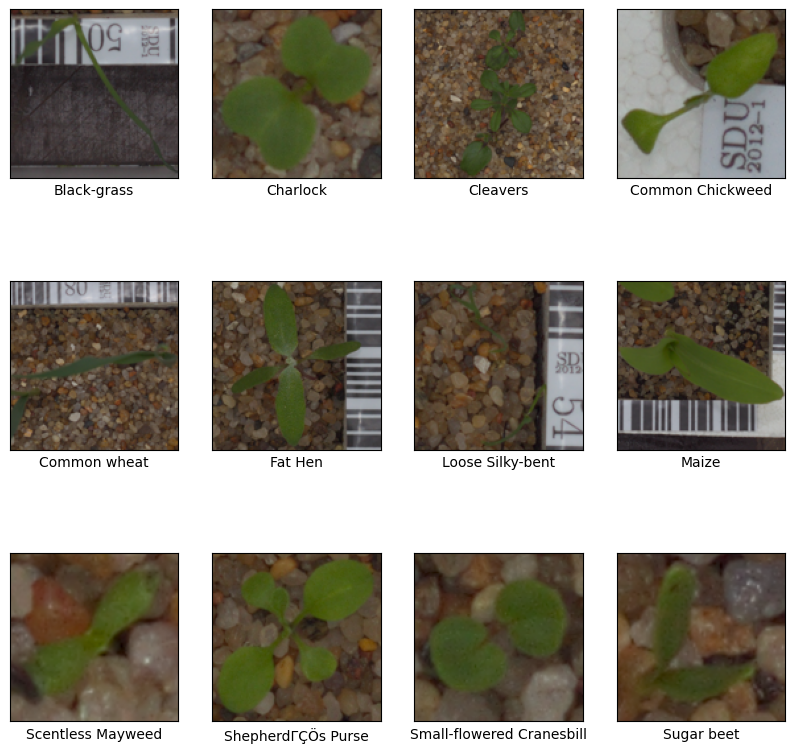

In [6]:
labels = df['Label'].unique()
plt.figure(figsize = (10,10))
for i, l in enumerate(labels[:12]):
    image = df[df['Label'] == l]['Image'].sample(1).values[0]
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(l)
plt.show()

### Data Exploration Steps

##### Steps to check data quality issues:

1) The random seeds were set in Numpy,Python and tensorflow and also the Tensorflow deterministic operations were set to 1 to make sure all operations such as sampling, shuffling and data augmentation produces consistent and reproducible results each time.
2) Images were loaded from different subfolders using glob function and created a dataframe with image and label colums (name of labels were from subfolder names) and all the images were converted to RGB and resized to 128x128 to maintain consistency and for memory efficiency.
3) Checked to see if there are any missing images or labels in the dataset.
4) Using .value_counts(), found that the data is imbalanced and would require either upsampling, downsampling, data augmentation or weighted loss functions to balance all the labels.
5) 1 random image from each unique label were displayed in a 3x4 plot grid to get an understanding of image quality and label representation of the images per label.

##### Evaluation Metrics suitable for the dataset:

As this is a classification task, the proper evaluation metrics which fit this dataset are:

1) Accuracy to measure correct prediction across all classes.
2) Precision to evaluate when the model predicted positive are truly positive.
3) Recall to evaluate out of all the true positives which are correctly identified.
4) F1 which balances between precision and recall.
5) Confusion matrix to give a full breakdown of true positives, false positives, true negatives and false negatives.

# Data Preprocessing

In [7]:
df['Label'] = df['Label'].replace('ShepherdΓÇÖs Purse','Shepherds Purse')

In [8]:
y = df['Label']
X = df['Image']

In [9]:
X_train_whole,X_test,y_train_whole,y_test = train_test_split(X,y,test_size = 0.2,stratify = y, random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train_whole,y_train_whole,test_size = 0.2, stratify = y_train_whole, random_state = 42)

In [10]:
train_df = pd.DataFrame({'Image' : X_train,'Label' : y_train}) 
len(train_df)

7089

In [11]:
max_size = train_df['Label'].value_counts().max()
resampled_group = []
for label,group in train_df.groupby('Label'):
    group_resampled = resample (group,n_samples = max_size, random_state = 42)
    resampled_group.append(group_resampled)
train_df_balanced = pd.concat(resampled_group)
train_df_balanced = train_df_balanced.sample(frac = 1, random_state = 42)
train_df_balanced = train_df_balanced.reset_index(drop = True)

In [12]:
train_df_balanced['Label'].value_counts()

Label
Sugar beet                   975
Cleavers                     975
Fat Hen                      975
Shepherds Purse              975
Common Chickweed             975
Scentless Mayweed            975
Black-grass                  975
Charlock                     975
Loose Silky-bent             975
Common wheat                 975
Small-flowered Cranesbill    975
Maize                        975
Name: count, dtype: int64

In [13]:
X_train = train_df_balanced['Image']
y_train = train_df_balanced['Label']

In [14]:
X_train = np.stack(X_train.values)
X_val = np.stack(X_val.values)
X_test = np.stack(X_test.values)
y_train = np.stack(y_train.values)
y_val = np.stack(y_val.values)
y_test = np.stack(y_test.values)

In [15]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_val = X_val.astype('float32')/255

In [16]:
ohe = OneHotEncoder(sparse_output = False)
y_train_array = np.array(y_train).reshape(-1,1)
y_val_array = np.array(y_val).reshape(-1,1)
y_test_array = np.array(y_test).reshape(-1,1)
y_train_encoded = ohe.fit_transform(y_train_array.reshape(-1,1))
y_val_encoded = ohe.transform(y_val_array.reshape(-1,1))
y_test_encoded = ohe.transform(y_test_array.reshape(-1,1))

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', seed = 42),
    layers.RandomRotation(0.2, seed = 42),
    layers.RandomZoom(0.1, seed = 42)
    ])

### Data Preprocessing

1. The incorrect label name of the image was changed from ShepherdΓÇÖs Purse to Shepherd's Purse.
2. The data was split into training (80%) and testing (20%), and further the training data was split into training (80%) and validation (20%).
3. Due to class imbalance the training data was oversampled with the random rows from the minority classes being duplicated to match the size of the majority class, and so all the labels will now have the same number of images.
4. The images were converted from a list to numpy array and then converted to float 32 and divided by 255 to normalise the images to scale it between 0 and 1 which is suitable for training CNNs. 
5. The labels were one hot encoded for multiclass classification.
6. Data augmentation is prepared with random rotations, flips and zooms which may needed to be applied to the CNN model if overfitting is spotted, as duplicated rows during oversampling may cause overfitting.

# Model Building

In [18]:
model = Sequential([
    keras.Input(shape = (128,128,3)),
    data_augmentation,
    
    layers.ZeroPadding2D(padding = 2),
    layers.Conv2D(32, kernel_size = (3,3), strides = (2,2)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(rate = 0.3),
    
    layers.ZeroPadding2D(padding = 2),
    layers.Conv2D(64, kernel_size = (3,3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(rate = 0.3),
    
    layers.ZeroPadding2D(padding = 2),
    layers.Conv2D(128, kernel_size = (3,3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(rate = 0.3),
    
    layers.Flatten(),
    layers.Dense(12,activation = 'softmax')
])              
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 132, 132, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 65, 65, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 36, 36, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 21, 21, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       124,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,572 (853.80 KB)

 Trainable params: 218,124 (852.05 KB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
early_stop = EarlyStopping( monitor = 'val_loss',patience = 10, restore_best_weights = True, verbose = 1)

In [20]:
start_time = time.time()
batch_size = 32
epochs = 80
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
cnn_model = model.fit(X_train,y_train_encoded, validation_data = (X_val,y_val_encoded), batch_size = batch_size, epochs = epochs, callbacks = [early_stop], verbose = 1)
end_time = time.time()

Epoch 1/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 120s 293ms/step - accuracy: 0.4446 - loss: 1.9995 - val_accuracy: 0.1151 - val_loss: 7.9714
Epoch 2/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 105s 286ms/step - accuracy: 0.6913 - loss: 0.9415 - val_accuracy: 0.5347 - val_loss: 1.8712
Epoch 3/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 94s 257ms/step - accuracy: 0.7897 - loss: 0.6446 - val_accuracy: 0.6018 - val_loss: 1.4580
Epoch 4/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 100s 274ms/step - accuracy: 0.8283 - loss: 0.5143 - val_accuracy: 0.7349 - val_loss: 0.8441
Epoch 5/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 108s 294ms/step - accuracy: 0.8558 - loss: 0.4349 - val_accuracy: 0.6300 - val_loss: 1.2027
Epoch 6/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 97s 266ms/step - accuracy: 0.8651 - loss: 0.3843 - val_accuracy: 0.8122 - val_loss: 0.5495
Epoch 7/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 108s 294ms/step - accuracy: 0.8825 - loss: 0.3426 - val_accuracy: 0.7479 - val_loss: 0.7291
Epoch 8/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 127s 348ms/step - accuracy: 0.8900 - l

In [21]:
elapsed_time = end_time - start_time
minutes = int(elapsed_time//60)
seconds = elapsed_time%60
print(minutes,'minutes' ,seconds,'seconds')

107 minutes 34.283512592315674 seconds


### Model Building

1. A sequential CNN model was built with a softmax layer at the end for performing multiclass classification.
2. The model was then compiled and trained on the training data.
3. The starting and ending time from model compilation to fitting was recorded.

# Experimental Table to Compare Different Models

| Model Number | Model Changes | Runtime | Training Accuracy Score | Training Loss | Validation Accuracy Score | Validation Loss |
|----|--------------|-------------|------|---------------------------|-----------------|--------|
| 1 |Built a model with 1 layer having 16 filters, batch size 64, Adam optimizer, categorical crossentropy loss and early stopping on validation loss with a patience of 10. The model is overfitting. | 8 minutes 50.85 seconds | 0.9979 | 0.0293 | 0.7834 | 0.7839 |
| 2 |Increased filters to 32 for the model to learn more features. Slight validation accuracy improvement and lower loss, but model is still overfitting. | 16 minutes 36.77 seconds | 0.9977 | 0.0273 | 0.8060 | 0.7139 |
| 3 |Added an additional layer, with one layer having 32 filters and the other having 64 filters so the model could learn more complex patterns and minor validation accuracy improvement, lower loss and model still overfitting. | 49 minutes 23.16 seconds | 0.9751 | 0.0968 | 0.8110 | 0.6748 |
| 4 |Added 2 dropout layers, with rates of 0.3 to reduce overfitting, but validation accuracy decreased, loss increased and overfitting persists. | 73 minutes 32.99 seconds | 0.9403 | 0.2115 | 0.7891 | 0.7861 |
| 5 |Added 2 max pooling layers to reduce model complexity, and increased the dropout rates to 0.4 for more regularization. Slight validation accuracy improvement, decrease in loss, the model is still overfitting. | 23 minutes 16.22 seconds | 0.9399 | 0.2212 | 0.8015 | 0.7146 |
| 6 |Added data augmentation layer for image variation for better generalization by training on new unseen images and reduce overfitting, and reduced batch size to 32 also for better generalization. Validation accuracy improved, loss decreased, and overfitting is also greatly reduced. | 83 minutes 46.20 seconds | 0.9498 | 0.1471 | 0.8596 | 0.4380 |
| 7 |Added 2 batch normalization layers for faster convergence and regularization and reduced epochs to 50 for faster training as batch normalization increases training duration. Validation accuracy improved, loss reduced, and overfitting decreased, but training time increased a lot. | 250 minutes 13.78 seconds | 0.9580 | 0.1223 | 0.9092 | 0.2811 |
| 8 | Added additional convolutional layer with 128 filters, batch normalization, max pooling and dropout layer,and the dropout rate reduced to 0.3 again, to reduce regularization for better accuracy. Validation accuracy improved, loss decreased, but training time increased even further. | 269 minutes 2.04 seconds | 0.9791 | 0.0546 | 0.9363 | 0.2388 |
| 9 | Added strides of 2 to the first layer, to reduce feature map size faster and increase training speed. Runtime was much shorter, but the validation accuracy decreased and loss increased. | 36 minutes 56.48 seconds | 0.9348 | 0.1817 | 0.9148 | 0.2662 |
| 10 | Added zero padding of 2 to each layer to preserve spatial dimensions and increased epochs to 80 as due to the zero padding the model became more stable and accuracy kept on getting better with more epochs and so wanted to acheive the best model performance,which helped to acheieve the best validation accuracy and lowest loss, and the model training was also significantly faster than model 8.| 107 minutes 34.28 seconds | 0.9759 | 0.0652 | 0.9419 | 0.2032 |


In [22]:
best_epoch = np.argmin(cnn_model.history['val_loss'])
train_acc = cnn_model.history['accuracy'][best_epoch]
train_loss = cnn_model.history['loss'][best_epoch]
val_acc = cnn_model.history['val_accuracy'][best_epoch]
val_loss = cnn_model.history['val_loss'][best_epoch]
print('Training Accuracy: ',train_acc,',','Training Loss: ',train_loss,',','Validation Accuracy: ',val_acc,',','Validation Loss: ',val_loss)

Training Accuracy:  0.9758974313735962 , Training Loss:  0.06520406156778336 , Validation Accuracy:  0.9419063925743103 , Validation Loss:  0.20322583615779877


### Validation Data Evaluation

1. The best epoch was recorded based on the lowest validation loss and then it was used to record the best training accuracy and loss and best validation accuracy and loss.

# Model Assessment on Test Data

In [25]:
original_labels = ohe.categories_[0]
y_pred = model.predict(X_test)
y_pred_1 = np.argmax(y_pred, axis = 1)
y_pred_labels = original_labels[y_pred_1] 
y_test_1 = np.argmax(y_test_encoded, axis = 1)
y_test_labels = original_labels[y_test_1]

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


The Test accuracy is:  0.9444945848375451
Test Recall Score:  0.9404862126024098
Test Precision Score:  0.9361737467025462
Test F1 Score:  0.9378615097326679


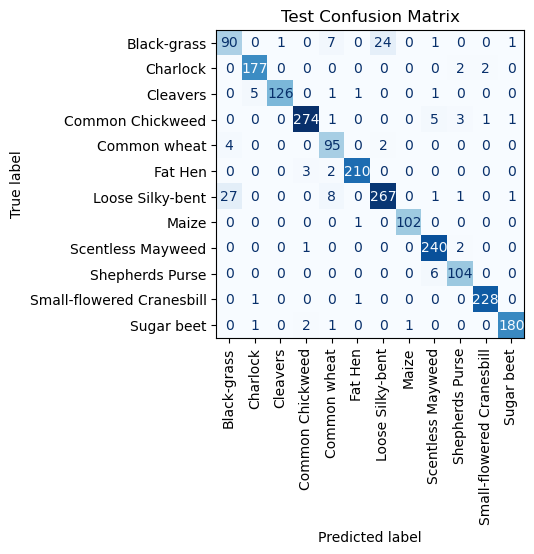

In [26]:
print('The Test accuracy is: ', accuracy_score(y_test_labels,y_pred_labels))
print('Test Recall Score: ', recall_score(y_test_labels,y_pred_labels, average = 'macro'))
print('Test Precision Score: ', precision_score(y_test_labels,y_pred_labels, average = 'macro'))
print('Test F1 Score: ', f1_score(y_test_labels,y_pred_labels, average = 'macro'))
cm_test = confusion_matrix(y_test_labels,y_pred_labels)
fig,ax = plt.subplots(figsize = (4,4))
disp = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = original_labels)
disp.plot(cmap = 'Blues', ax = ax, colorbar = False)
ax.set_xticklabels(original_labels, rotation = 90)
ax.set_title('Test Confusion Matrix')
plt.show()

### Model Final Assessment

1. Based on the best validation accuracy and lowest validation loss, model 10 from the experiment table was chosen and used for the final model assessment on the test dataset.
2. The accuracy, precision, recall and f1 score was calculated for a good understanding of the model's overall classification performance and the confusion matrix was used to see the label wise performance.
3. All the metrics had a really high score which shows the model is very accurately able to distinguish between labels on unseen data.

# Final Discussion



### Overall Strengths of the Pipeline

1. High F1 score when evaluated on test data which shows the model performs well across all labels.
2. Overfitting has been minimised by using various regularization techniques, which helps in the overall model performance.
3. Variations of the images via data augmentation makes the pipeline robust across different conditions thus reducing the chances of overfitting.

### Overall Limitations of the Pipeline

1. Training the data is very intensive on the computer which makes the training duration very long.
2. Performance may not be same across extreme conditions.
3. The pipeline requires a lots of images for training which could be expensive.

### Business Implications

1. This pipeline helps automate weed detection, which helps to avoid manual detection and so reduces the overall costs.
2. Early and fast detection will now be possible thus helping in having greater yields of maize and common wheat, thus increasing profits.

### Data Driven Recommendations

1. Adding more images with different angles, lighting conditions and different extreme conditions to make the model more robust.
2. If the model is retrained periodically with new crops or weed images, it will remain accurate.

### Informative Features of the Model

The model relies on the different leaf sizes, shapes and colours of the crops and weeds for accurately distinguishing between different weed plants and crops.

### Model Explainability

The model is not fully explanable, while the number of images used for training, overall training duration and performance are known, but the parts of the image which are being used for predictions cannot be seen so cannot be explained.

### Deployment

The model is suitable for deployment, preferably with computers with a powerful GPU for faster and more efficient training, and then can be integrated into automatic weed detection systems.